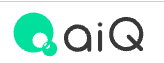

[disclaimer](../../disclaimer.txt/)

# aiQ DataHub: aiQ POS Csmr Goods Evaluation Notebook
- aiQ POS Csmr Goods consolidates sales data for products sold in retail stores such as supermarkets, drugstores, and convenience stores, organized by TICKER.
- Prescription medications, fresh foods without barcodes, and other similar items are not included in the product coverage.

In [1]:
# Commands to automatically update custom modules.
%load_ext autoreload
%autoreload 2

## Step1: Import Library

In [2]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import plotly.io
from aiq_strategy_robot.data.data_accessor import DAL

if '../..' not in sys.path:
    sys.path.append('../..')

from libs.dataset import aiq_pos_csmr_goods as sc_goods
from libs.dataset import common as sc_common
from libs.path import DEFAULT_DIR

- Create an instance of the standard data handler.
- The data handler is an object that holds libraries for data retrieval and data processing.

In [3]:
sdh = DAL()

## Step2: Load Data to `sdh`
Since the focus here is on demonstrating data analysis, the data will be loaded through a simple loader that has been prepared separately.

In [4]:
sdh.extract.clear()

# Register various demo data into the data handler (`sdh`).
data_id_alt = sc_goods.register_csmr_goods_data(sdh, data_dir=DEFAULT_DIR)
tickers = sdh.get_raw_data(data_id_alt).index.get_level_values('TICKER').unique().to_list()
data_id_mkt = sc_common.register_market(sdh, tickers)
data_id_funda = sc_common.register_fundamental(sdh)

# Check the registered `data_id`.
display(sdh.extract_definition)

category data_source   source    table           alias  \
data_id                                                          
1        RawData    external   sample  Unknown  pos_csmr_goods   
2        RawData    External  Unknown  Unknown  market_returns   
3        RawData    External  Unknown  Unknown           funda   

                                                   tickers  \
data_id                                                      
1        [1301, 1332, 1333, 1334, 1352, 1378, 1379, 138...   
2        [1301, 1332, 1333, 1334, 1352, 1378, 1379, 138...   
3        [1301, 1332, 1333, 1334, 1352, 1378, 1379, 138...   

                      index       start_datetime         end_datetime  
data_id                                                                
1        [TICKER, DATETIME]  2008-03-16 00:00:00  2024-09-29 00:00:00  
2        [TICKER, DATETIME]  2000-01-04 00:00:00  2024-10-29 00:00:00  
3        [TICKER, DATETIME]  2007-04-20 00:00:00  2024-05-31 00:00:00

In [5]:
# Randomly select a TICKER to use as a sample for plotting.
sample_target = "2281"

In [6]:
display(sdh.get_raw_data(data_id_alt).tail())
display(sdh.get_raw_data(data_id_mkt).tail())
display(sdh.get_raw_data(data_id_funda).tail())

VARIABLE           pos_sales     share  unit_price  unit_price_vs_ind
TICKER DATETIME                                                      
9997   2024-09-01   0.003606  0.000201    0.822752           0.580583
       2024-09-08   0.004539  0.000251    1.004957           0.707059
       2024-09-15   0.002677  0.000148    0.992262           0.700182
       2024-09-22   0.004025  0.000218    1.040915           0.729593
       2024-09-29   0.003051  0.000161    0.950448           0.679405

returns  returns_oo  returns_id  returns_on
TICKER DATETIME                                                
9997   2024-10-21 -0.009675   -0.004129   -0.006920   -0.002755
       2024-10-22  0.004158    0.004129   -0.006892    0.011050
       2024-10-23 -0.023794   -0.011050   -0.019636   -0.004158
       2024-10-24 -0.002837   -0.025318    0.002845   -0.005682
       2024-10-25 -0.011429    0.000000   -0.008584   -0.002845

sales_yoy
TICKER DATETIME             
9997   2023-03-31   0.008141
       2023-06-30  -0.030340
       2023-09-30  -0.024041
       2023-12-31  -0.024655
       2024-03-31   0.001886

> If you want to use your own financial data with the handler, please set the following flag to True. <br> Note that the sample financial data has already been adjusted for YoY.

In [7]:
USE_MY_FUNDA = False 

> If you want to use your own market data with the handler, please set the following flag to True. <br> Note that the sample market data has already been adjusted for Returns.

In [8]:
USE_MY_MKT = False 

## Step3: Correlation Analysis

### Create `AltDataEvaluator`
Given the nature of aiQ POS Csmr Goods data, it is expected that there is a correlation with financial data (quarterly sales).

We will test this hypothesis here to determine its validity.

#### The `AltDataEvaluator` will be used for evaluating alternative data.

In [9]:
from aiq_strategy_robot.evaluator import AltDataEvaluator

# Initialize AltDataEvaluator
ade = AltDataEvaluator(sdh)

# Configure the settings so that the calculation process logs are not output. (Setting it to True will enable logging)
sdh.transform.verbose = False

#### Retrieve the features from aiQ POS Csmr Goods and store them for later use.

In [10]:
features = sdh.get_raw_data(data_id_alt).columns
features

Index(['pos_sales', 'share', 'unit_price', 'unit_price_vs_ind'], dtype='object', name='VARIABLE')

#### Compare the quarterly sales data loaded in Step 2 with the `pos_sales` from POS Csmr Goods
- To make the comparison possible, resample the `pos_sales` data to match the frequency of the quarterly sales data.

In [11]:
sdh.transform.clear()
funda_Q_defs = sdh.transform.raw(data_id=data_id_funda).variables
funda_Q_defs

variable_id  data_id root_field return_type other_roots  \
variable_name                                                              
Funda_Sales_yoy            1        3  sales_yoy           -           -   

                step_001  
variable_name             
Funda_Sales_yoy    raw()

In [12]:
alt_Q_defs = sdh.transform.resample_by(label=funda_Q_defs.index[0], func='mean', data_id=data_id_alt).variables
alt_Q_defs

variable_id  data_id  \
variable_name                                                              
PosCsmrGoods_Pos_sales_ResampledBy(label="Funda...            6        1   
PosCsmrGoods_Share_ResampledBy(label="Funda_Sal...            7        1   
PosCsmrGoods_Unit_price_ResampledBy(label="Fund...            8        1   
PosCsmrGoods_Unit_price_vs_ind_ResampledBy(labe...            9        1   

                                                           root_field  \
variable_name                                                           
PosCsmrGoods_Pos_sales_ResampledBy(label="Funda...          pos_sales   
PosCsmrGoods_Share_ResampledBy(label="Funda_Sal...              share   
PosCsmrGoods_Unit_price_ResampledBy(label="Fund...         unit_price   
PosCsmrGoods_Unit_price_vs_ind_ResampledBy(labe...  unit_price_vs_ind   

                                                   return_type other_roots  \
variable_name                                                                
PosCsmrGoods_Pos_sales_ResampledBy(label="Funda...           -           -   
PosCsmrGoods_Share_ResampledBy(label="Funda_Sal...           -           -   
PosCsmrGoods_Unit_price_ResampledBy(label="Fund...           -           -   
PosCsmrGoods_Unit_price_vs_ind_ResampledBy(labe...           -           -   

                                                   step_001  \
variable_name                                                 
PosCsmrGoods_Pos_sales_ResampledBy(label="Funda...    raw()   
PosCsmrGoods_Share_ResampledBy(label="Funda_Sal...    raw()   
PosCsmrGoods_Unit_price_ResampledBy(label="Fund...    raw()   
PosCsmrGoods_Unit_price_vs_ind_ResampledBy(labe...    raw()   

                                                                                             step_002  
variable_name                                                                                          
PosCsmrGoods_Pos_sales_ResampledBy(label="Funda...  resample_by(label="Funda_Sales_yoy", func="mean")  
PosCsmrGoods_Share_ResampledBy(label="Funda_Sal...  resample_by(label="Funda_Sales_yoy", func="mean")  
PosCsmrGoods_Unit_price_ResampledBy(label="Fund...  resample_by(label="Funda_Sales_yoy", func="mean")  
PosCsmrGoods_Unit_price_vs_ind_ResampledBy(labe...  resample_by(label="Funda_Sales_yoy", func="mean")

## Step 3.1: Plotting with Quarterly Sales

Plot the quarterly sales data alongside the alternative data to visually inspect the data shapes.
> It is recommended to compare with your own financial data before applying YoY adjustments.

#### Create Variables from the Base `variable` and Visually Identify Which Matches the Financial Data
- By using `sdh.transform`, you can create various variables and quickly evaluate which one has the strongest relationship with the financial data.
- For a list of `transform` processes, please refer to the sample notebook provided with the `data handler`.

In [13]:
if USE_MY_FUNDA:

    # Plot the data to visually inspect its shape.
    sdh.show_line_one_target(
        target=sample_target, # Decide which TICKER's data to plot.
        y=funda_Q_defs.index[0], # Specify the data to be displayed on the y-axis using the `variable_id`.
        X= alt_Q_defs.index, # Specify the data to be displayed on the x-axis using a list of `variable_id`s (use a list when displaying multiple graphs simultaneously).
        col_num=2, # Decide how many graphs to display in a single row.
        vname_len_limit=30, # The title will display the variable names of the X `variable_id`s, but you can specify a character limit to shorten the display.
    )
    
    # Use `resample_by` to resample the data so that it is aggregated according to the dates of the financial data.
    alt_Q_shift_defs = sdh.transform.shift(data_id=data_id_alt, periods=[0, 1, 2, 3, 4]).resample_by(label=funda_Q_defs.index[0], func='mean').variables

    # View Sales vs Pos Sales
    sdh.show_line_one_target(
        target=sample_target,
        y=funda_Q_defs.index[0],
        X=[alt_Q_shift_defs.iloc[0].name, alt_Q_shift_defs.iloc[4].name,
           alt_Q_shift_defs.iloc[8].name, alt_Q_shift_defs.iloc[12].name],
        col_num=2
    )

    # For the next step, calculate the year-over-year (YoY) change and create a variable with an additional lagged difference to address cases where trends might cause apparent correlations.
    sales_def = sdh.transform.log_diff(fields=funda_Q_ids, periods=4).diff(periods=1).variables

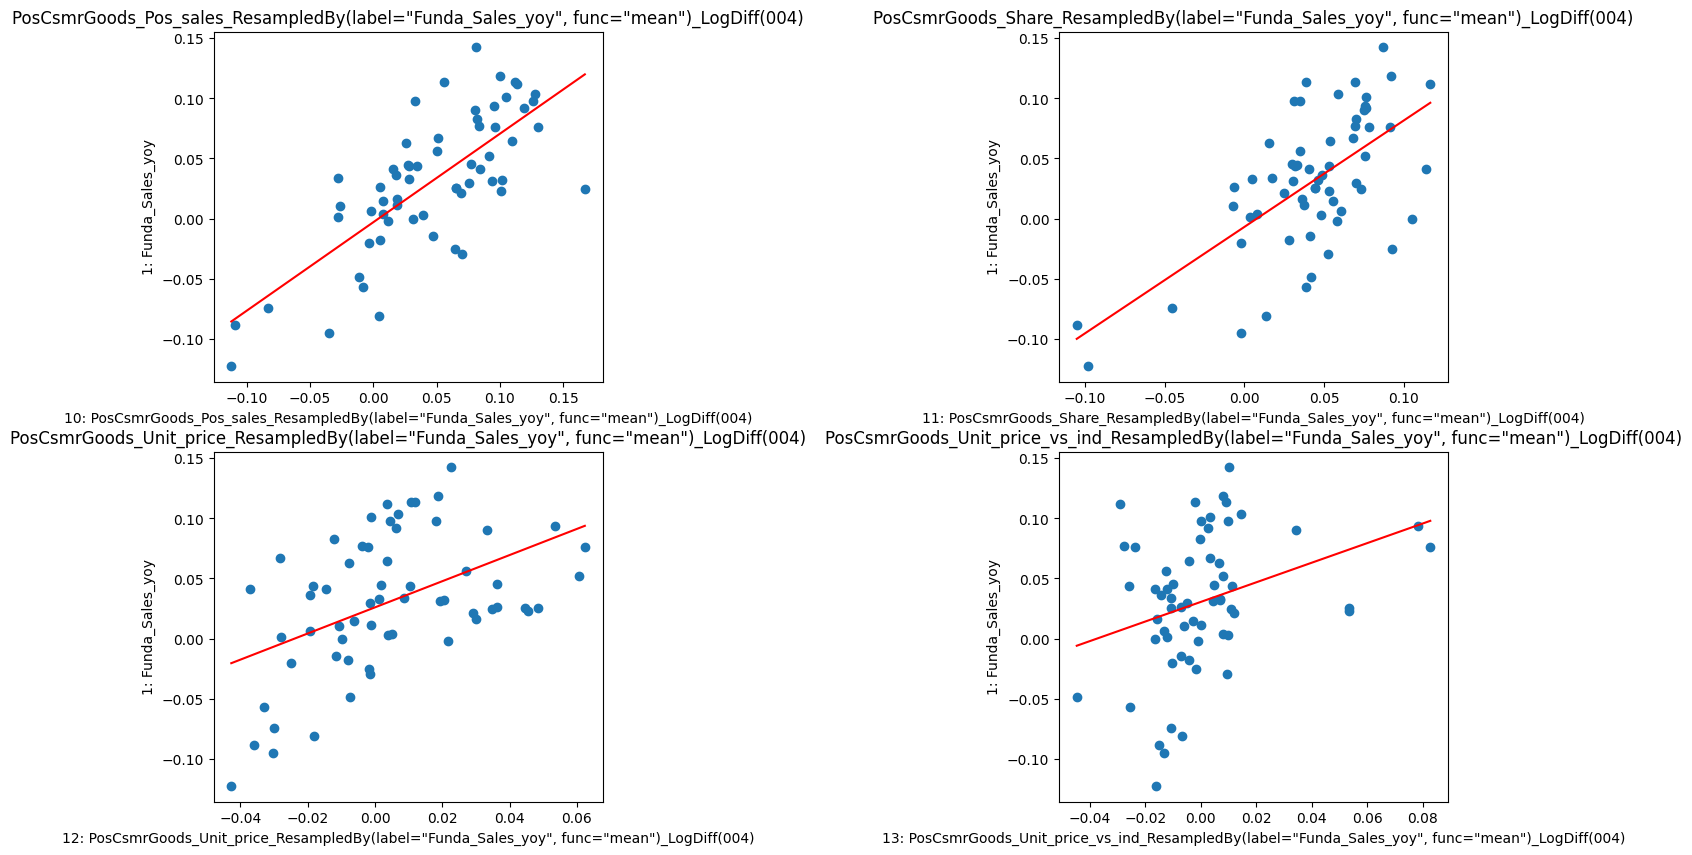

variable_id  data_id  \
variable_name                                                              
PosCsmrGoods_Unit_price_vs_ind_Shifted(003)_Res...           49        1   
PosCsmrGoods_Pos_sales_Shifted(004)_ResampledBy...           50        1   
PosCsmrGoods_Share_Shifted(004)_ResampledBy(lab...           51        1   
PosCsmrGoods_Unit_price_Shifted(004)_ResampledB...           52        1   
PosCsmrGoods_Unit_price_vs_ind_Shifted(004)_Res...           53        1   

                                                           root_field  \
variable_name                                                           
PosCsmrGoods_Unit_price_vs_ind_Shifted(003)_Res...  unit_price_vs_ind   
PosCsmrGoods_Pos_sales_Shifted(004)_ResampledBy...          pos_sales   
PosCsmrGoods_Share_Shifted(004)_ResampledBy(lab...              share   
PosCsmrGoods_Unit_price_Shifted(004)_ResampledB...         unit_price   
PosCsmrGoods_Unit_price_vs_ind_Shifted(004)_Res...  unit_price_vs_ind   

                                                   return_type other_roots  \
variable_name                                                                
PosCsmrGoods_Unit_price_vs_ind_Shifted(003)_Res...           -           -   
PosCsmrGoods_Pos_sales_Shifted(004)_ResampledBy...           -           -   
PosCsmrGoods_Share_Shifted(004)_ResampledBy(lab...           -           -   
PosCsmrGoods_Unit_price_Shifted(004)_ResampledB...           -           -   
PosCsmrGoods_Unit_price_vs_ind_Shifted(004)_Res...           -           -   

                                                            step_001  \
variable_name                                                          
PosCsmrGoods_Unit_price_vs_ind_Shifted(003)_Res...  shift(periods=3)   
PosCsmrGoods_Pos_sales_Shifted(004)_ResampledBy...  shift(periods=4)   
PosCsmrGoods_Share_Shifted(004)_ResampledBy(lab...  shift(periods=4)   
PosCsmrGoods_Unit_price_Shifted(004)_ResampledB...  shift(periods=4)   
PosCsmrGoods_Unit_price_vs_ind_Shifted(004)_Res...  shift(periods=4)   

                                                                                             step_002  
variable_name                                                                                          
PosCsmrGoods_Unit_price_vs_ind_Shifted(003)_Res...  resample_by(label="Funda_Sales_yoy", func="mean")  
PosCsmrGoods_Pos_sales_Shifted(004)_ResampledBy...  resample_by(label="Funda_Sales_yoy", func="mean")  
PosCsmrGoods_Share_Shifted(004)_ResampledBy(lab...  resample_by(label="Funda_Sales_yoy", func="mean")  
PosCsmrGoods_Unit_price_Shifted(004)_ResampledB...  resample_by(label="Funda_Sales_yoy", func="mean")  
PosCsmrGoods_Unit_price_vs_ind_Shifted(004)_Res...  resample_by(label="Funda_Sales_yoy", func="mean")

variable_id  data_id root_field return_type  \
variable_name                                                            
Funda_Sales_yoy_Diff(001)           54        3  sales_yoy           -   

                          other_roots step_001         step_002  
variable_name                                                    
Funda_Sales_yoy_Diff(001)           -    raw()  diff(periods=1)

In [14]:
if not USE_MY_FUNDA:
    
    # Convert `pos_sales` to YoY as well for comparison with the financial data.
    alt_Q_yoy_defs = sdh.transform.log_diff(periods=4, fields=alt_Q_defs.index).variables
    
    # Plot the data to visually inspect its shape.
    sdh.show_scatter_one_target(
        target=sample_target,
        y=funda_Q_defs.index[0],
        X=alt_Q_yoy_defs.index,
        col_num=2
    )

    # Use `resample_by` to resample the data so that it is aggregated according to the dates of the financial data.
    alt_Q_shift_defs = sdh.transform.shift(data_id=data_id_alt, periods=[0, 1, 2, 3, 4]).resample_by(label=funda_Q_defs.index[0], func='mean').variables

    # To address cases where trends might cause apparent correlations, create a variable with an additional lagged difference.
    sales_def = sdh.transform.diff(fields=funda_Q_defs.index, periods=1).variables
    sales_nm = sales_def.iloc[0].name

    display(alt_Q_shift_defs.tail())
    display(sales_def)

#### Verify using variables that have been lagged with the first difference of the alternative data features.

In [15]:
alt_Q_shift_logdiff_defs = sdh.transform.log_diff(fields=alt_Q_shift_defs.index, periods=4).diff(periods=1).variables
display(alt_Q_shift_logdiff_defs.head())

variable_id  data_id  \
variable_name                                                              
PosCsmrGoods_Pos_sales_Shifted(000)_ResampledBy...           75        1   
PosCsmrGoods_Share_Shifted(000)_ResampledBy(lab...           76        1   
PosCsmrGoods_Unit_price_Shifted(000)_ResampledB...           77        1   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...           78        1   
PosCsmrGoods_Pos_sales_Shifted(001)_ResampledBy...           79        1   

                                                           root_field  \
variable_name                                                           
PosCsmrGoods_Pos_sales_Shifted(000)_ResampledBy...          pos_sales   
PosCsmrGoods_Share_Shifted(000)_ResampledBy(lab...              share   
PosCsmrGoods_Unit_price_Shifted(000)_ResampledB...         unit_price   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...  unit_price_vs_ind   
PosCsmrGoods_Pos_sales_Shifted(001)_ResampledBy...          pos_sales   

                                                   return_type other_roots  \
variable_name                                                                
PosCsmrGoods_Pos_sales_Shifted(000)_ResampledBy...           -           -   
PosCsmrGoods_Share_Shifted(000)_ResampledBy(lab...           -           -   
PosCsmrGoods_Unit_price_Shifted(000)_ResampledB...           -           -   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...           -           -   
PosCsmrGoods_Pos_sales_Shifted(001)_ResampledBy...           -           -   

                                                            step_001  \
variable_name                                                          
PosCsmrGoods_Pos_sales_Shifted(000)_ResampledBy...  shift(periods=0)   
PosCsmrGoods_Share_Shifted(000)_ResampledBy(lab...  shift(periods=0)   
PosCsmrGoods_Unit_price_Shifted(000)_ResampledB...  shift(periods=0)   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...  shift(periods=0)   
PosCsmrGoods_Pos_sales_Shifted(001)_ResampledBy...  shift(periods=1)   

                                                                                             step_002  \
variable_name                                                                                           
PosCsmrGoods_Pos_sales_Shifted(000)_ResampledBy...  resample_by(label="Funda_Sales_yoy", func="mean")   
PosCsmrGoods_Share_Shifted(000)_ResampledBy(lab...  resample_by(label="Funda_Sales_yoy", func="mean")   
PosCsmrGoods_Unit_price_Shifted(000)_ResampledB...  resample_by(label="Funda_Sales_yoy", func="mean")   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...  resample_by(label="Funda_Sales_yoy", func="mean")   
PosCsmrGoods_Pos_sales_Shifted(001)_ResampledBy...  resample_by(label="Funda_Sales_yoy", func="mean")   

                                                               step_003  \
variable_name                                                             
PosCsmrGoods_Pos_sales_Shifted(000)_ResampledBy...  log_diff(periods=4)   
PosCsmrGoods_Share_Shifted(000)_ResampledBy(lab...  log_diff(periods=4)   
PosCsmrGoods_Unit_price_Shifted(000)_ResampledB...  log_diff(periods=4)   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...  log_diff(periods=4)   
PosCsmrGoods_Pos_sales_Shifted(001)_ResampledBy...  log_diff(periods=4)   

                                                           step_004  
variable_name                                                        
PosCsmrGoods_Pos_sales_Shifted(000)_ResampledBy...  diff(periods=1)  
PosCsmrGoods_Share_Shifted(000)_ResampledBy(lab...  diff(periods=1)  
PosCsmrGoods_Unit_price_Shifted(000)_ResampledB...  diff(periods=1)  
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...  diff(periods=1)  
PosCsmrGoods_Pos_sales_Shifted(001)_ResampledBy...  diff(periods=1)

#### Execute the correlation calculations one by one.

In [16]:
rho_pool = ade.compu_rho_by_df(alt_Q_shift_logdiff_defs, sales_def, group_by='step_001')
display(rho_pool.xs('t-val', level=1).sort_values(rho_pool.columns[0], ascending=False))

shift(periods=0)  shift(periods=1)  shift(periods=2)  \
pos_sales                 14.281716         11.293393          8.392855   
share                      5.036026          4.380503          3.579565   
unit_price_vs_ind          1.457893          1.030885          0.412140   
unit_price                 0.069402         -0.991227         -1.667975   

                   shift(periods=3)  shift(periods=4)  
pos_sales                  5.910773          4.744649  
share                      2.622629          3.571879  
unit_price_vs_ind         -0.319128         -0.782297  
unit_price                -2.578199         -2.652899

In [17]:
# Retrieve the results from the contents of the pooled DataFrame.
display(rho_pool.xs('rho', level=1).sort_values(rho_pool.columns[0], ascending=False))

shift(periods=0)  shift(periods=1)  shift(periods=2)  \
pos_sales                  0.123615          0.098061          0.073046   
share                      0.043884          0.038192          0.031223   
unit_price_vs_ind          0.012715          0.008994          0.003597   
unit_price                 0.000605         -0.008648         -0.014554   

                   shift(periods=3)  shift(periods=4)  
pos_sales                  0.051837          0.041641  
share                      0.023025          0.031360  
unit_price_vs_ind         -0.002802         -0.006872  
unit_price                -0.022635         -0.023297

#### Correlation values can also be calculated on a Ticker-by-Ticker basis
- Below, the top 5 TICKERs are selected, and their relationships are plotted.

In [18]:
alt_Q_shift_1_logdiff_defs = sdh.transform.search_applied_methods(alt_Q_shift_logdiff_defs, {'step_001': 'shift(periods=1)'})
rho_time = ade.compu_rho(alt_Q_shift_1_logdiff_defs.index, sales_nm, by='ticker', rename_features=alt_Q_shift_1_logdiff_defs.root_field)
rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).head()

pos_sales     share  unit_price  unit_price_vs_ind
TICKER                                                    
2226     9.500869  6.554818   -0.042537           0.298083
2220     7.280671  5.711003   -0.434502          -1.965568
2804     6.135112  0.524333    1.046190          -1.138697
2208     5.889190  1.437646    2.672743           1.524452
2908     5.538624  0.398367    0.781101           0.905671

In [19]:
rho_time = ade.compu_rho_by_df(alt_Q_shift_logdiff_defs, sales_def, 'step_001', by='ticker')
rho_time.loc['shift(periods=1)'].T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).head()

pos_sales     share  unit_price  unit_price_vs_ind
TICKER                                                    
2226     9.500869  6.554818   -0.042537           0.298083
2220     7.280671  5.711003   -0.434502          -1.965568
2804     6.135112  0.524333    1.046190          -1.138697
2208     5.889190  1.437646    2.672743           1.524452
2908     5.538624  0.398367    0.781101           0.905671

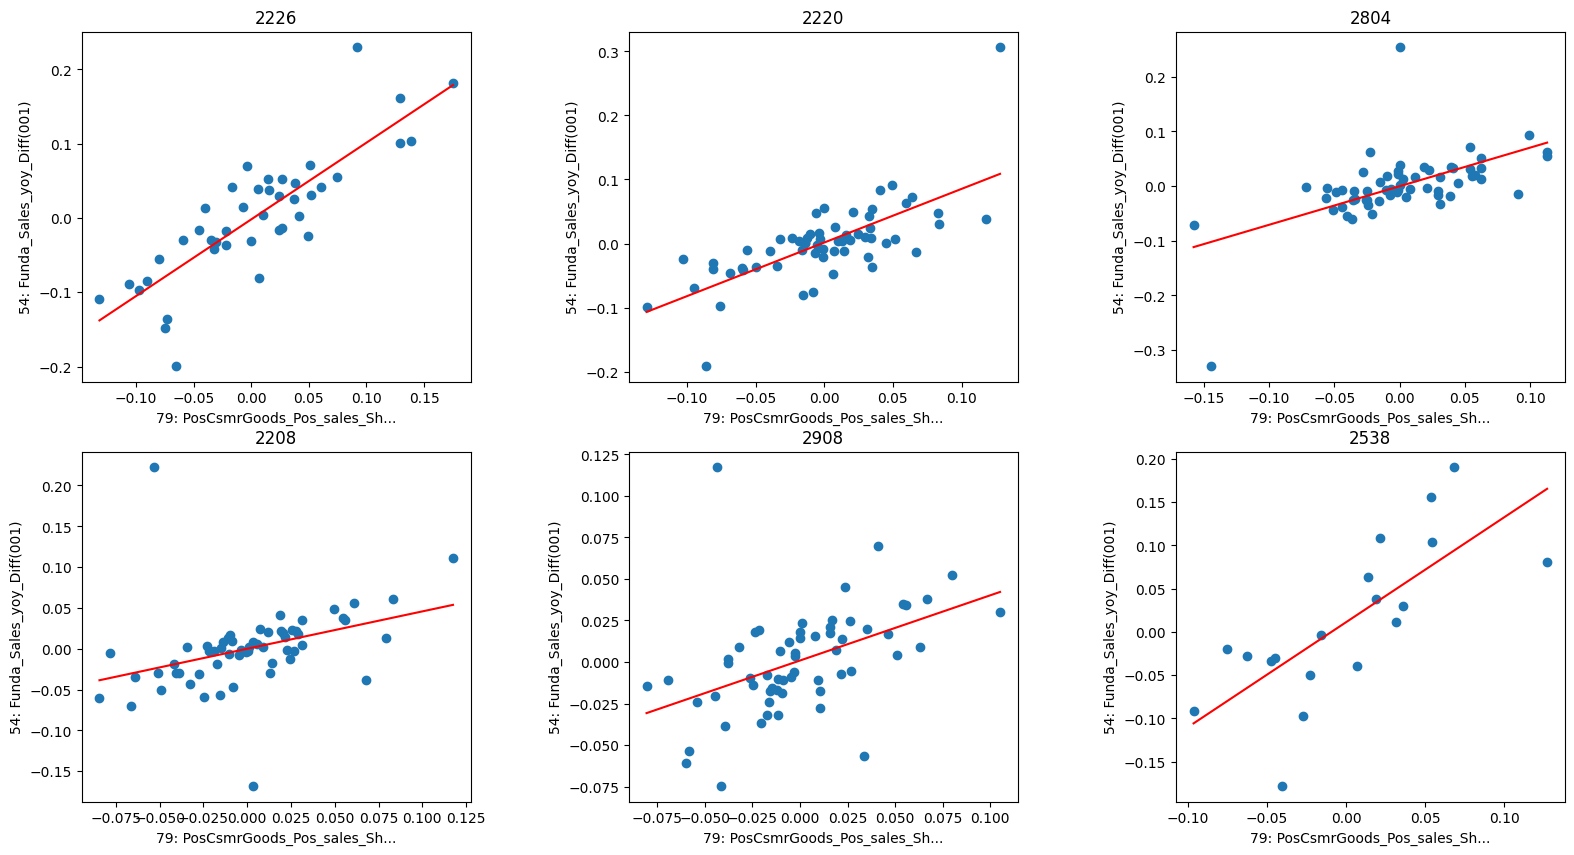

In [20]:
top6tickers = rho_time.loc['shift(periods=1)'].T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).index[:6]

sdh.show_scatter_per_target(
    y=sales_nm,
    x=alt_Q_shift_1_logdiff_defs.index[0],
    targets=top6tickers,
    col_num=3,
    vname_len_limit=25,
)

### Step 3.2: Correlation with Stock Price Changes
- Having confirmed a strong relationship between financial data and POS Csmr Goods, the next step is to examine the correlation with stock price changes.
- To align the stock price data with the POS data, resample it to weekly data for comparison.

In [21]:
if USE_MY_MKT:
     mkt_W_close = sdh.transform.resample(data_id=data_id_mkt, rule='W', fields='close', func='last').variables
else:
     mkt_W_close = sdh.transform.fillna(0, data_id=data_id_mkt, fields='returns').cumsum().exp().resample(rule='W', func='last').variables
mkt_W_close_nm = mkt_W_close.iloc[0].name

alt_defs = sdh.transform.raw(data_id=data_id_alt).variables
alt_defs = pd.concat([alt_defs,  sdh.transform.mul(data_id=data_id_alt, x1field='pos_sales', x2field='unit_price').variables])
alt_defs = pd.concat([alt_defs,  sdh.transform.mul(data_id=data_id_alt, x1field='pos_sales', x2field='share').variables])
alt_W_defs = sdh.transform.resample(rule='W', func='mean', fields=alt_defs.index).variables

display(mkt_W_close)
display(alt_W_defs)

variable_id  data_id  \
variable_name                                                              
MarketReturns_Returns_Fillna(value=0)_CumSum()_...           98        2   

                                                   root_field return_type  \
variable_name                                                               
MarketReturns_Returns_Fillna(value=0)_CumSum()_...    returns           -   

                                                   other_roots  \
variable_name                                                    
MarketReturns_Returns_Fillna(value=0)_CumSum()_...           -   

                                                           step_001  step_002  \
variable_name                                                                   
MarketReturns_Returns_Fillna(value=0)_CumSum()_...  fillna(value=0)  cumsum()   

                                                   step_003  \
variable_name                                                 
MarketReturns_Returns_Fillna(value=0)_CumSum()_...    exp()   

                                                                                             step_004  
variable_name                                                                                          
MarketReturns_Returns_Fillna(value=0)_CumSum()_...  resample(rule="W", func="last", origin="start_...

variable_id  data_id  \
variable_name                                                              
PosCsmrGoods_Pos_sales_Resampled(W|mean, origin...          101        1   
PosCsmrGoods_Share_Resampled(W|mean, origin="st...          102        1   
PosCsmrGoods_Unit_price_Resampled(W|mean, origi...          103        1   
PosCsmrGoods_Unit_price_vs_ind_Resampled(W|mean...          104        1   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...          105        1   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Share)_...          106        1   

                                                           root_field  \
variable_name                                                           
PosCsmrGoods_Pos_sales_Resampled(W|mean, origin...          pos_sales   
PosCsmrGoods_Share_Resampled(W|mean, origin="st...              share   
PosCsmrGoods_Unit_price_Resampled(W|mean, origi...         unit_price   
PosCsmrGoods_Unit_price_vs_ind_Resampled(W|mean...  unit_price_vs_ind   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...          pos_sales   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Share)_...          pos_sales   

                                                   return_type    other_roots  \
variable_name                                                                   
PosCsmrGoods_Pos_sales_Resampled(W|mean, origin...           -              -   
PosCsmrGoods_Share_Resampled(W|mean, origin="st...           -              -   
PosCsmrGoods_Unit_price_Resampled(W|mean, origi...           -              -   
PosCsmrGoods_Unit_price_vs_ind_Resampled(W|mean...           -              -   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...           -  [1]unit_price   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Share)_...           -       [1]share   

                                                   step_001  \
variable_name                                                 
PosCsmrGoods_Pos_sales_Resampled(W|mean, origin...        -   
PosCsmrGoods_Share_Resampled(W|mean, origin="st...        -   
PosCsmrGoods_Unit_price_Resampled(W|mean, origi...        -   
PosCsmrGoods_Unit_price_vs_ind_Resampled(W|mean...        -   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...    raw()   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Share)_...    raw()   

                                                                                step_002  \
variable_name                                                                              
PosCsmrGoods_Pos_sales_Resampled(W|mean, origin...                                 raw()   
PosCsmrGoods_Share_Resampled(W|mean, origin="st...                                 raw()   
PosCsmrGoods_Unit_price_Resampled(W|mean, origi...                                 raw()   
PosCsmrGoods_Unit_price_vs_ind_Resampled(W|mean...                                 raw()   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...  mul(x2field=PosCsmrGoods_Unit_price)   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Share)_...       mul(x2field=PosCsmrGoods_Share)   

                                                                                             step_003  
variable_name                                                                                          
PosCsmrGoods_Pos_sales_Resampled(W|mean, origin...  resample(rule="W", func="mean", origin="start_...  
PosCsmrGoods_Share_Resampled(W|mean, origin="st...  resample(rule="W", func="mean", origin="start_...  
PosCsmrGoods_Unit_price_Resampled(W|mean, origi...  resample(rule="W", func="mean", origin="start_...  
PosCsmrGoods_Unit_price_vs_ind_Resampled(W|mean...  resample(rule="W", func="mean", origin="start_...  
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...  resample(rule="W", func="mean", origin="start_...  
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Share)_...  resample(rule="W", func="mean", origin="start_...

#### Plotting with Stock Prices

Similar to the comparison with financial data, plot the data to understand its shape and structure.

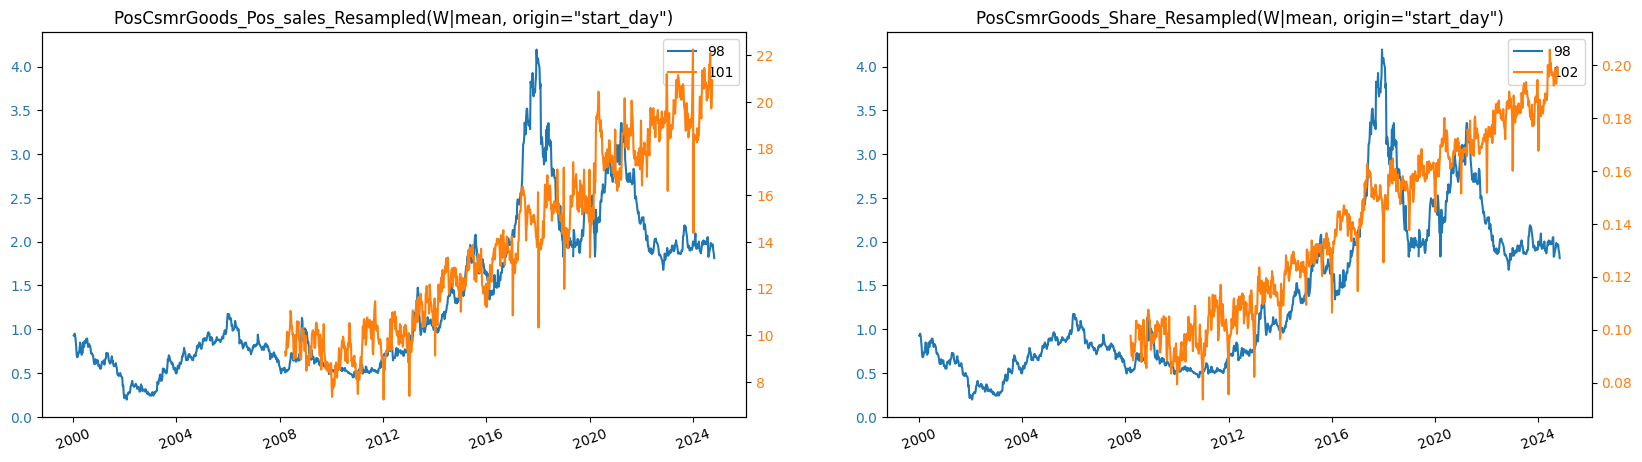

In [22]:
sdh.show_line_one_target(
    target=sample_target,
    y=mkt_W_close_nm,
    X=alt_W_defs.index[:2],
    col_num=2
)

##### Explore the Optimal Shift Interval in the Same Way as the Comparison with Financial Data

In [23]:
alt_W_shift_x_SMA_defs = sdh.transform.shift(fields=alt_defs.index, periods=[0, 1, 2, 3, 4, 5, 6, 7, 8]).resample(rule='W', func='mean').sma(periods=[4, 8, 12]).variables
display(alt_W_shift_x_SMA_defs.head())

variable_id  data_id  \
variable_name                                                              
PosCsmrGoods_Pos_sales_Shifted(000)_Resampled(W...          195        1   
PosCsmrGoods_Share_Shifted(000)_Resampled(W|mea...          196        1   
PosCsmrGoods_Unit_price_Shifted(000)_Resampled(...          197        1   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...          198        1   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...          199        1   

                                                           root_field  \
variable_name                                                           
PosCsmrGoods_Pos_sales_Shifted(000)_Resampled(W...          pos_sales   
PosCsmrGoods_Share_Shifted(000)_Resampled(W|mea...              share   
PosCsmrGoods_Unit_price_Shifted(000)_Resampled(...         unit_price   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...  unit_price_vs_ind   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...          pos_sales   

                                                   return_type    other_roots  \
variable_name                                                                   
PosCsmrGoods_Pos_sales_Shifted(000)_Resampled(W...           -              -   
PosCsmrGoods_Share_Shifted(000)_Resampled(W|mea...           -              -   
PosCsmrGoods_Unit_price_Shifted(000)_Resampled(...           -              -   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...           -              -   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...           -  [1]unit_price   

                                                   step_001  \
variable_name                                                 
PosCsmrGoods_Pos_sales_Shifted(000)_Resampled(W...        -   
PosCsmrGoods_Share_Shifted(000)_Resampled(W|mea...        -   
PosCsmrGoods_Unit_price_Shifted(000)_Resampled(...        -   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...        -   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...    raw()   

                                                                                step_002  \
variable_name                                                                              
PosCsmrGoods_Pos_sales_Shifted(000)_Resampled(W...                                     -   
PosCsmrGoods_Share_Shifted(000)_Resampled(W|mea...                                     -   
PosCsmrGoods_Unit_price_Shifted(000)_Resampled(...                                     -   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...                                     -   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...  mul(x2field=PosCsmrGoods_Unit_price)   

                                                            step_003  \
variable_name                                                          
PosCsmrGoods_Pos_sales_Shifted(000)_Resampled(W...  shift(periods=0)   
PosCsmrGoods_Share_Shifted(000)_Resampled(W|mea...  shift(periods=0)   
PosCsmrGoods_Unit_price_Shifted(000)_Resampled(...  shift(periods=0)   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...  shift(periods=0)   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...  shift(periods=0)   

                                                                                             step_004  \
variable_name                                                                                           
PosCsmrGoods_Pos_sales_Shifted(000)_Resampled(W...  resample(rule="W", func="mean", origin="start_...   
PosCsmrGoods_Share_Shifted(000)_Resampled(W|mea...  resample(rule="W", func="mean", origin="start_...   
PosCsmrGoods_Unit_price_Shifted(000)_Resampled(...  resample(rule="W", func="mean", origin="start_...   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...  resample(rule="W", func="mean", origin="start_...   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...  resample(rule="W", func="mean", origin="start_...   

                                                          step_005  
variable_name                             

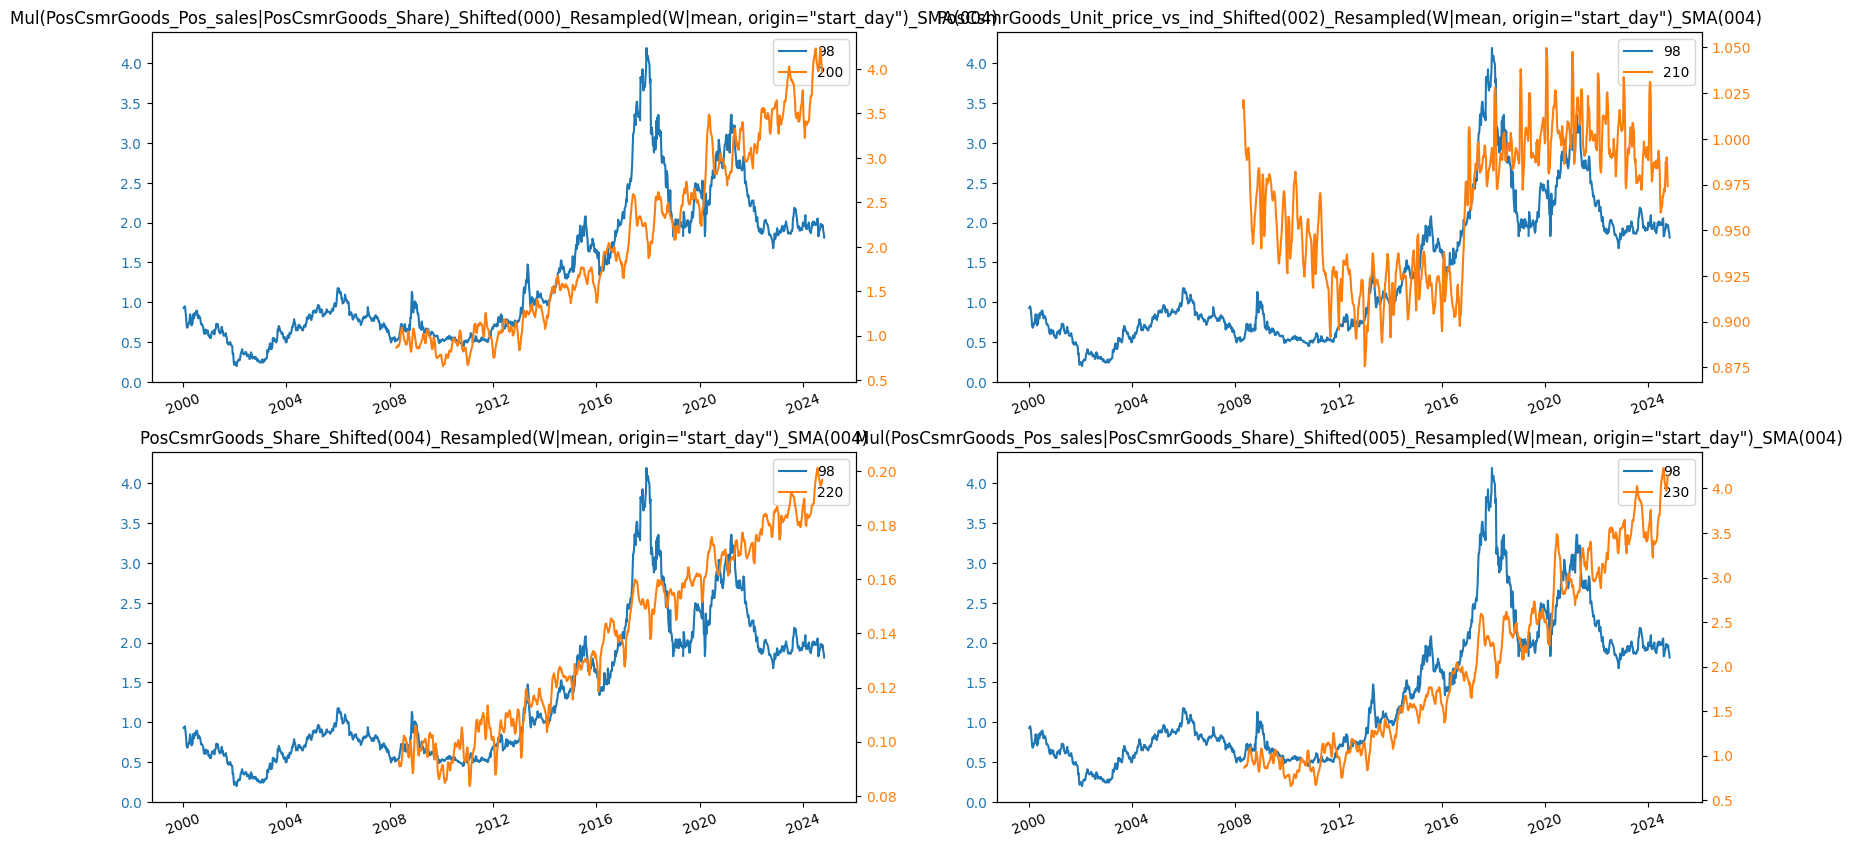

In [24]:
# View Sales vs Pos Sales
sdh.show_line_one_target(
    target=sample_target,
    y=mkt_W_close_nm,
    X=[alt_W_shift_x_SMA_defs.index[5], alt_W_shift_x_SMA_defs.index[15], 
       alt_W_shift_x_SMA_defs.index[25], alt_W_shift_x_SMA_defs.index[35]],
    col_num=2
)

> Make `return`

In [25]:
close_ret = sdh.transform.dropna(fields=mkt_W_close.iloc[0].name, how='all').calc_return(name='ret').variables

> Calculate the year-over-year (YoY) change for the same week before performing the correlation analysis.

In [26]:
alt_W_shift_x_sma12_logdiff_defs = sdh.transform.log_diff(fields=alt_W_shift_x_SMA_defs.index, periods=52).variables
display(alt_W_shift_x_sma12_logdiff_defs.head())

variable_id  data_id  \
variable_name                                                              
PosCsmrGoods_Pos_sales_Shifted(000)_Resampled(W...          359        1   
PosCsmrGoods_Share_Shifted(000)_Resampled(W|mea...          360        1   
PosCsmrGoods_Unit_price_Shifted(000)_Resampled(...          361        1   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...          362        1   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...          363        1   

                                                           root_field  \
variable_name                                                           
PosCsmrGoods_Pos_sales_Shifted(000)_Resampled(W...          pos_sales   
PosCsmrGoods_Share_Shifted(000)_Resampled(W|mea...              share   
PosCsmrGoods_Unit_price_Shifted(000)_Resampled(...         unit_price   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...  unit_price_vs_ind   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...          pos_sales   

                                                   return_type    other_roots  \
variable_name                                                                   
PosCsmrGoods_Pos_sales_Shifted(000)_Resampled(W...           -              -   
PosCsmrGoods_Share_Shifted(000)_Resampled(W|mea...           -              -   
PosCsmrGoods_Unit_price_Shifted(000)_Resampled(...           -              -   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...           -              -   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...           -  [1]unit_price   

                                                   step_001  \
variable_name                                                 
PosCsmrGoods_Pos_sales_Shifted(000)_Resampled(W...        -   
PosCsmrGoods_Share_Shifted(000)_Resampled(W|mea...        -   
PosCsmrGoods_Unit_price_Shifted(000)_Resampled(...        -   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...        -   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...    raw()   

                                                                                step_002  \
variable_name                                                                              
PosCsmrGoods_Pos_sales_Shifted(000)_Resampled(W...                                     -   
PosCsmrGoods_Share_Shifted(000)_Resampled(W|mea...                                     -   
PosCsmrGoods_Unit_price_Shifted(000)_Resampled(...                                     -   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...                                     -   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...  mul(x2field=PosCsmrGoods_Unit_price)   

                                                            step_003  \
variable_name                                                          
PosCsmrGoods_Pos_sales_Shifted(000)_Resampled(W...  shift(periods=0)   
PosCsmrGoods_Share_Shifted(000)_Resampled(W|mea...  shift(periods=0)   
PosCsmrGoods_Unit_price_Shifted(000)_Resampled(...  shift(periods=0)   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...  shift(periods=0)   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...  shift(periods=0)   

                                                                                             step_004  \
variable_name                                                                                           
PosCsmrGoods_Pos_sales_Shifted(000)_Resampled(W...  resample(rule="W", func="mean", origin="start_...   
PosCsmrGoods_Share_Shifted(000)_Resampled(W|mea...  resample(rule="W", func="mean", origin="start_...   
PosCsmrGoods_Unit_price_Shifted(000)_Resampled(...  resample(rule="W", func="mean", origin="start_...   
PosCsmrGoods_Unit_price_vs_ind_Shifted(000)_Res...  resample(rule="W", func="mean", origin="start_...   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...  resample(rule="W", func="mean", origin="start_...   

                                                          step_005  \
variable_name                            

> Calculate the correlation coefficient and its T-value.

In [27]:
# We can see which variables have higher correlations.
rho_pool = ade.compu_rho_by_df(alt_W_shift_x_sma12_logdiff_defs, close_ret, group_by=['step_003', 'step_005'])
display(rho_pool.xs('t-val', level=1).sort_values(rho_pool.columns[0], ascending=False))

shift(periods=0) shift(periods=1) shift(periods=2)  \
                          sma(periods=4)   sma(periods=4)   sma(periods=4)   
pos_sales                       5.091728         6.003649         6.292051   
pos_sales*[1]share              4.562147         5.684960         5.647684   
pos_sales*[1]unit_price         4.034439         4.991966         5.690915   
share                           2.833071         3.457043         2.984774   
unit_price_vs_ind              -0.154090        -0.063496         0.765674   
unit_price                     -0.273554         0.225526         1.071482   

                        shift(periods=3) shift(periods=4) shift(periods=5)  \
                          sma(periods=4)   sma(periods=4)   sma(periods=4)   
pos_sales                       5.967466         6.148243         5.313416   
pos_sales*[1]share              5.472038         5.564879         4.724553   
pos_sales*[1]unit_price         5.367346         5.646934         5.300984   
share                           2.867311         3.258647         2.469533   
unit_price_vs_ind               0.407851         0.167831         0.128257   
unit_price                      0.723044         0.662512         0.535784   

                        shift(periods=6) shift(periods=7) shift(periods=8)  \
                          sma(periods=4)   sma(periods=4)   sma(periods=4)   
pos_sales                       5.068349         5.647227         5.662508   
pos_sales*[1]share              4.529187         4.691202         4.691420   
pos_sales*[1]unit_price         4.907125         5.388508         5.241351   
share                           2.396538         2.158381         2.039416   
unit_price_vs_ind               0.327854         0.471141         0.791350   
unit_price                      0.682425         1.118867         0.798500   

                        shift(periods=0)  ... shift(periods=8)  \
                          sma(periods=8)  ...   sma(periods=8)   
pos_sales                       6.222168  ...         5.183179   
pos_sales*[1]share              5.811276  ...         4.463617   
pos_sales*[1]unit_price         5.214436  ...         5.066201   
share                           3.466127  ...         2.114828   
unit_price_vs_ind              -0.003563  ...         0.254724   
unit_price                      0.270226  ...         1.127973   

                        shift(periods=0) shift(periods=1) shift(periods=2)  \
                         sma(periods=12)  sma(periods=12)  sma(periods=12)   
pos_sales                       6.817532         6.959911         6.459427   
pos_sales*[1]share              5.840852         5.875655         5.492314   
pos_sales*[1]unit_price         5.967243         6.203073         6.066154   
share                           3.427641         3.406050         3.068335   
unit_price_vs_ind               0.085862         0.036928         0.300579   
unit_price                      0.648855         0.704997         0.870460   

                        shift(periods=3) shift(periods=4) shift(periods=5)  \
                         sma(periods=12)  sma(periods=12)  sma(periods=12)   
pos_sales                       6.481483         6.340710         5.823638   
pos_sales*[1]share              5.516548         5.526400         5.198184   
pos_sales*[1]unit_price         6.083737         6.140887         5.795488   
share                           2.881085         2.925738         2.664094   
unit_price_vs_ind               0.455535         0.319300         0.555597   
unit_price                      1.050349         1.145922         1.315868   

                        shift(periods=6) shift(periods=7) shift(periods=8)  
                         sma(periods=12)  sma(periods=12)  sma(periods=12)  
pos_sales                       5.271178         5.163006         4.656909  
pos_sales*[1]share              4.721655         4.461871         3.954535  
pos_sales*[1]unit_price         4.949192         4.887747     

> Select the top N Tickers with the highest correlation and visually inspect their relationships using scatter plots.

In [28]:
alt_W_shift_3_sma12_logdiff_defs = sdh.transform.search_applied_methods(alt_W_shift_x_sma12_logdiff_defs, {'step_003': 'shift(periods=3)', 'step_005': 'sma(periods=12)'})

In [29]:
rho_time1 = ade.compu_rho_by_df(alt_W_shift_3_sma12_logdiff_defs, close_ret, 'step_003', by='ticker')
rho_time1.droplevel(0).T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).head()

pos_sales     share  unit_price  unit_price_vs_ind  \
TICKER                                                       
5194     3.870530  3.897354    2.227272           1.858516   
2820     2.828942  2.476676    1.263806           0.926593   
2884     2.789609  0.379986    0.328930           1.314583   
2281     2.780883  2.710441    1.961673           0.276581   
2216     2.670711  1.248752    1.316146           0.862744   

        pos_sales*[1]unit_price  pos_sales*[1]share  
TICKER                                               
5194                   3.955602            3.946415  
2820                   2.655242            2.771247  
2884                   2.609010            2.226325  
2281                   2.796428            3.018721  
2216                   2.765690            2.243399

## Step 4: Quantile Backtest
- Based on the variables created in Step 3, various factors will be generated and calculations will be performed.
- Here, the 12-week moving average of `pos_sales` is selected as the factor value.
- In practice, you should vary hyperparameters such as the moving average period and shift intervals to ensure that the backtest results are not significantly affected.

In [30]:
# Create a tercile (three-quantile) portfolio.
nq = 3

# Assume one-way transaction costs.
exe_cost = 0.0005

In [31]:
df_of_pick = alt_W_shift_3_sma12_logdiff_defs.copy()
display(df_of_pick)

pos_sales = df_of_pick.index[0]
share = df_of_pick.index[1]
unit_price =  df_of_pick.index[2]
pos_sales_and_uprice = df_of_pick.loc[df_of_pick['other_roots'].str.contains('unit_price')].index[0]
pos_sales_and_share = df_of_pick.loc[df_of_pick['other_roots'].str.contains('share')].index[0]

variable_id  data_id  \
variable_name                                                              
PosCsmrGoods_Pos_sales_Shifted(003)_Resampled(W...          485        1   
PosCsmrGoods_Share_Shifted(003)_Resampled(W|mea...          486        1   
PosCsmrGoods_Unit_price_Shifted(003)_Resampled(...          487        1   
PosCsmrGoods_Unit_price_vs_ind_Shifted(003)_Res...          488        1   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...          489        1   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Share)_...          490        1   

                                                           root_field  \
variable_name                                                           
PosCsmrGoods_Pos_sales_Shifted(003)_Resampled(W...          pos_sales   
PosCsmrGoods_Share_Shifted(003)_Resampled(W|mea...              share   
PosCsmrGoods_Unit_price_Shifted(003)_Resampled(...         unit_price   
PosCsmrGoods_Unit_price_vs_ind_Shifted(003)_Res...  unit_price_vs_ind   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...          pos_sales   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Share)_...          pos_sales   

                                                   return_type    other_roots  \
variable_name                                                                   
PosCsmrGoods_Pos_sales_Shifted(003)_Resampled(W...           -              -   
PosCsmrGoods_Share_Shifted(003)_Resampled(W|mea...           -              -   
PosCsmrGoods_Unit_price_Shifted(003)_Resampled(...           -              -   
PosCsmrGoods_Unit_price_vs_ind_Shifted(003)_Res...           -              -   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...           -  [1]unit_price   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Share)_...           -       [1]share   

                                                   step_001  \
variable_name                                                 
PosCsmrGoods_Pos_sales_Shifted(003)_Resampled(W...        -   
PosCsmrGoods_Share_Shifted(003)_Resampled(W|mea...        -   
PosCsmrGoods_Unit_price_Shifted(003)_Resampled(...        -   
PosCsmrGoods_Unit_price_vs_ind_Shifted(003)_Res...        -   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...    raw()   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Share)_...    raw()   

                                                                                step_002  \
variable_name                                                                              
PosCsmrGoods_Pos_sales_Shifted(003)_Resampled(W...                                     -   
PosCsmrGoods_Share_Shifted(003)_Resampled(W|mea...                                     -   
PosCsmrGoods_Unit_price_Shifted(003)_Resampled(...                                     -   
PosCsmrGoods_Unit_price_vs_ind_Shifted(003)_Res...                                     -   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...  mul(x2field=PosCsmrGoods_Unit_price)   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Share)_...       mul(x2field=PosCsmrGoods_Share)   

                                                            step_003  \
variable_name                                                          
PosCsmrGoods_Pos_sales_Shifted(003)_Resampled(W...  shift(periods=3)   
PosCsmrGoods_Share_Shifted(003)_Resampled(W|mea...  shift(periods=3)   
PosCsmrGoods_Unit_price_Shifted(003)_Resampled(...  shift(periods=3)   
PosCsmrGoods_Unit_price_vs_ind_Shifted(003)_Res...  shift(periods=3)   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...  shift(periods=3)   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Share)_...  shift(periods=3)   

                                                                                             step_004  \
variable_name                                                                                           
PosCsmrGoods_Pos_sales_Shifted(003)_Resampled(W...  resample(rule="W", func="mean", origin="start_...   
PosCsmrGoods_Share_Shifted(003)_Resampled(W|mea...  resample(rule="W", func

### Try pos_sales factor

In [32]:
dfqret, stats, dfsigqt = ade.q_backtest(
    pos_sales,
    close_ret.iloc[0].name,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

cum.Ret   ann.Ret   ann.Std       R/R     Win_R  \
001 #1           1.354990  0.057638  0.140301  0.410815  0.585947   
    #2           1.384113  0.058489  0.136154  0.429577  0.579674   
    #3           3.886589  0.109373  0.141044  0.775451  0.594730   
    #3-#1        1.043876  0.047879  0.047902  0.999526  0.560853   
    #3-#1(cost)  0.951409  0.044710  0.047895  0.933491  0.557089   

                 ann.TurnOver    Max_DD  Calmar Ratio  
001 #1               3.025435 -0.342770      0.168153  
    #2               5.404295 -0.325432      0.179726  
    #3               3.030446 -0.287799      0.380031  
    #3-#1            6.055881 -0.070205      0.681993  
    #3-#1(cost)      6.055881 -0.072168      0.619524

### Try pos_sales x share factor

In [33]:
dfqret, stats, dfsigqt = ade.q_backtest(
    pos_sales_and_share,
    close_ret.iloc[0].name,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

cum.Ret   ann.Ret   ann.Std       R/R     Win_R  \
001 #1           1.291025  0.055734  0.138775  0.401616  0.583438   
    #2           1.444960  0.060235  0.137453  0.438226  0.580928   
    #3           3.906935  0.109674  0.140917  0.778292  0.603513   
    #3-#1        1.117817  0.050318  0.046707  1.077315  0.570891   
    #3-#1(cost)  1.020977  0.047107  0.046708  1.008544  0.564617   

                 ann.TurnOver    Max_DD  Calmar Ratio  
001 #1               3.084330 -0.340948      0.163468  
    #2               5.286646 -0.332893      0.180945  
    #3               3.037655 -0.276255      0.397004  
    #3-#1            6.121984 -0.068230      0.737474  
    #3-#1(cost)      6.121984 -0.068947      0.683236

### We try pos_sales x unit_price composite factor too

In [34]:
dfqret, stats, dfsigqt = ade.q_backtest(
    pos_sales_and_uprice,
    close_ret.iloc[0].name,
    nq=5,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

cum.Ret   ann.Ret   ann.Std       R/R     Win_R  \
001 #1           1.294793  0.055848  0.143317  0.389680  0.588457   
    #2           0.957974  0.044939  0.134960  0.332985  0.564617   
    #3           1.991732  0.074328  0.138382  0.537120  0.574655   
    #4           2.864409  0.092469  0.139248  0.664063  0.589711   
    #5           3.701404  0.106572  0.150643  0.707449  0.590966   
    #5-#1        1.019050  0.047042  0.066000  0.712749  0.533250   
    #5-#1(cost)  0.911056  0.043283  0.065999  0.655808  0.530740   

                 ann.TurnOver    Max_DD  Calmar Ratio  
001 #1               3.773833 -0.367002      0.152173  
    #2               8.345082 -0.333546      0.134733  
    #3               9.628565 -0.307207      0.241946  
    #4               7.905747 -0.299639      0.308603  
    #5               3.415916 -0.300617      0.354512  
    #5-#1            7.189749 -0.107263      0.438562  
    #5-#1(cost)      7.189749 -0.110533      0.391582